In [1]:
import os
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn


# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
# which makes intuitive sense.
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import torch.multiprocessing as mp

from torchvision import transforms, datasets, models
from torchvision.io import read_image

np.random.seed(0)
torch.manual_seed(0)

In [2]:
# torch.cuda.current_device()
# torch.cuda.get_device_name(0)
# torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

Torch is using device: cuda:0


'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [3]:
def remove_fname_space(path):
    for filename in os.listdir(path):
        my_source = path + "/" + filename
        my_dest = path + "/" + filename.strip().replace(" ", "")
        os.rename(my_source, my_dest)

In [4]:
path_tr_real = '../../data/CIFAK/train/REAL'
# remove_fname_space(path_tr_real)

In [5]:
fname_tr_real = os.listdir(path_tr_real)
fname_tr_real.sort()
labels_lst=[1]*len(fname_tr_real)
# print(len(labels_lst))
# print(len(fname_tr_real))
tr_dict={'Image_name':fname_tr_real,'True?':labels_lst}
tr_df=pd.DataFrame(tr_dict)
tr_df.to_csv(path_tr_real+"/tr_annotation.csv")

fpath_tr_real = []
for i, file in enumerate(fname_tr_real):
    fpath_tr_real.append(path_tr_real+"/"+file)

In [6]:
img_size = cv2.imread(fpath_tr_real[0]).shape[0]

horizontal_slides= 6
total_img_slices = horizontal_slides**2
num_loader_images = 16

slice_width = img_size//horizontal_slides
slice_width

5

In [7]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # img: is a tensor of the shape (Color_Channels x Rows (Hight) x Columns (Width))
        #
        # Make a slice every "slice_width" as we are moving across dimension 1 (as we are moving
        # vertically across rows)
        img = img.unfold(1, self.slice_width, self.slice_width)
        # Make a slice every slice_width as we are moving across dimension 2,
        # Note that previous operation has added new dimension at the beginning
        # refers to no. of vertical slices, hence 2 here still refers to the rows.
        img = img.unfold(2, self.slice_width, self.slice_width)
        return img

    def plot(self, img):
        img = self.slice(img).permute(1, 2, 0, 3, 4)
        print(img.size())

        fig = plt.figure(figsize=(2, 2))
        grid = ImageGrid(fig, 111, nrows_ncols=(
            img.size(0), img.size(1)), axes_pad=0.1)

        for i, ax in enumerate(grid):
            i_b4 = str(np.base_repr(i, img.size(0))).zfill(2)
            row = int(i_b4[0])
            column = int(i_b4[1])
            patch = img[row][column].permute(1, 2, 0).numpy()
            ax.imshow(patch)
            ax.axis('off')

    def __call__(self, img):
        img = self.slice(img)
        channels = img.size(0)

        return img.reshape(-1, self.slice_width * self.slice_width * channels)

    plt.show()

Start by slicing each image [3,32,23] ==> [16,3,8,8]

In [8]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, images, annotations_file, transform=None):
        self.images = images
        self.labels = pd.read_csv(annotations_file)
        self.transform = transform

    def __getitem__(self, index):
        img = read_image(self.images[index])

        # img.to(device)

        labels = self.labels.iloc[index, 2]

        if self.transform:
            img_t = self.transform(img)

        return img, img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return len(self.images)

In [9]:
# Define the transforms on the input data (x) tensor
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((32, 32)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    SliceImage(slice_width=slice_width)
])

In [10]:
# Define the dataset object and configure the Data Loader
tr_annotation_file = path_tr_real+"/tr_annotation.csv"

Im_tr_dataset = Images_Dataset(fpath_tr_real, tr_annotation_file, data_transform)

Im_tr_loader = DataLoader(dataset=Im_tr_dataset,
                          batch_size=num_loader_images,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          num_workers=4)  # increase number of processor cores loading the data and getting it ready for model training inside the GPU

torch.Size([3, 32, 32])


(-0.5, 31.5, 31.5, -0.5)

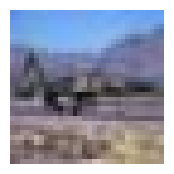

In [11]:
tr_img, tr_img_t, tr_labels = next(iter(Im_tr_loader))

img_sample = tr_img[0]
print(img_sample.size())
fig = plt.figure(figsize=(2, 2))
plt.imshow(img_sample.permute(1, 2, 0))
plt.axis('off')

torch.Size([6, 6, 3, 5, 5])


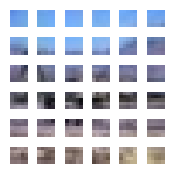

In [12]:
slice=SliceImage(slice_width)
slice.plot(img_sample)


In [13]:
# num_img_slices = 2
# num_loader_patches = 4
# flattened_size = 8
# hidden_size = 5

# inp = torch.rand(num_loader_patches, num_img_slices, flattened_size)
# print("image: ", inp.size())
# print("")

# projection = nn.Linear(flattened_size, hidden_size)
# res = projection(inp)

# print("image embedding: ", res.size())

# class_token = nn.Parameter(torch.rand(1, hidden_size)
#                            ).repeat(res.size(0), 1, 1)
# print("cls embedding: ", class_token.size())
# print("")

# res = torch.concat([class_token, res], dim=1)
# print("cls embedding + image embedding: ", res.size())

# position = nn.Parameter(torch.rand(
#     1, num_img_slices + 1, hidden_size)).repeat(res.size(0), 1, 1)
# print("Position embedding: ", position.size())
# print("")
# final=res+position
# print("cls embedding + image embedding + Position embedding: ", final.size())

In [14]:
class ImageEmbedding(nn.Module):

    def __init__(self, slice_input_size, slice_embed_size, img_slices, dropout_ratio=0.2):
        super().__init__()

        self.img_to_embed = nn.Linear(slice_input_size, slice_embed_size)
        self.cls_to_embed = nn.Parameter(torch.rand(1, slice_embed_size))
        self.pos_to_embed = nn.Parameter(torch.rand(1, img_slices + 1, slice_embed_size))

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, flattened_img):
        # the input is a batch of images each has been sliced to patches and each slice
        # has been flattened. i.e. the shape of the input is:
        # [no. of images ,no. of slices per image, size of the flattened image slice]
        # 
        img_embedding = self.embed(flattened_img)

        cls_embedding = self.cls_to_embed.repeat(img_embedding.size(0), 1, 1)
        img_embedding = torch.concat([cls_embedding, img_embedding], dim=1)

        position_embedding = self.pos_to_embed.repeat(
            img_embedding.size(0), 1, 1)

        img_and_pos_embedding = img_embedding + position_embedding
        return self.dropout(img_and_pos_embedding)

In [15]:
class AttentionHead(nn.Module):  
  
    def __init__(self, size): # size is hidden size 
        super(AttentionHead, self).__init__()  
  
        self.query = nn.Linear(size, size)  
        self.key = nn.Linear(size, size)  
        self.value = nn.Linear(size, size)  
  
    def forward(self, input_tensor):  
        q, k, v = self.query(input_tensor), self.key(input_tensor), self.value(input_tensor)  
  
        scale = q.size(1) ** 0.5  
        scores = torch.bmm(q, k.transpose(1, 2)) / scale  
  
        scores = F.softmax(scores, dim=-1)  
   
        output = torch.bmm(scores, v)  
        return output

In [16]:
class MultiHeadAttention(nn.Module):

    def __init__(self, size, num_heads):
        super().__init__()

        self.heads = nn.ModuleList([AttentionHead(size)
                                   for _ in range(num_heads)])
        self.linear = nn.Linear(size * num_heads, size)

    def forward(self, input_tensor):
        s = [head(input_tensor) for head in self.heads]
        s = torch.cat(s, dim=-1)

        output = self.linear(s)
        return output

In [17]:
class Encoder(nn.Module):  
  
    def __init__(self, size: int, num_heads: int, dropout: float = 0.1):  
        super().__init__()  
  
        self.attention = MultiHeadAttention(size, num_heads)  
        self.feed_forward = nn.Sequential(  
            nn.Linear(size, 4 * size),  
            nn.Dropout(dropout),  
            nn.GELU(),  
            nn.Linear(4 * size, size),  
            nn.Dropout(dropout)  
        )  
        self.norm_attention = nn.LayerNorm(size)  
        self.norm_feed_forward = nn.LayerNorm(size)  
  
    def forward(self, input_tensor):  
        attn = input_tensor + self.attention(self.norm_attention(input_tensor))  
        output = attn + self.feed_forward(self.norm_feed_forward(attn))  
        return output

In [18]:
class ViT(nn.Module):
    def __init__(self,
                 slice_input_size,
                 slice_embed_size,
                 img_slices,
                 num_classes,
                 num_heads,
                 num_encoders,
                 emb_dropout=0.1,
                 enc_dropout=0.1,
                 lr=1e-4, min_lr=4e-5,
                 weight_decay=0.1,
                 epochs=200):
        super().__init__()

        self.embedding = ImageEmbedding(
            slice_input_size=slice_input_size,
            slice_embed_size=slice_embed_size,
            img_slices=img_slices,
            dropout_ratio=emb_dropout)
        self.encoders = nn.Sequential(
            *[Encoder(slice_embed_size, num_heads, dropout=enc_dropout) for _ in range(num_encoders)],)
        self.mlp_head = nn.Linear(slice_embed_size, num_classes)

        self.lr = lr
        self.min_lr = min_lr
        self.weight_decay = weight_decay
        self.epochs = epochs

    def forward(self, flattened_img):
        emb = self.embedding(flattened_img)
        attn = self.encoders(emb)
        output = self.mlp_head(attn[:, 0, :])

        return output

In [19]:
# a1= torch.tensor([[[1,2],[3,4],[5,6]]])
# print(a1.size())
# a2= torch.tensor([[[10,20],[30,40]]])
# torch.bmm(a1,a2)